In [1]:
##### Libraries #####
import dotenv
dotenv.load_dotenv(".env")
import os
import time
import utils
import shutil
import argparse
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)
import models_tensorflow.EEGModels
from typing import Literal
from tensorflow.keras import backend
from tensorflow.keras import utils as tf_utils
backend.set_image_data_format("channels_last")
from sklearn.model_selection import train_test_split

import utils
from utils import Metric, plot_confusion_matrix, plot_history
from libs.dataset import BcicIv2aDataset, InnerSpeechDataset

In [2]:
os.environ["DATASET_DIR"] = 'datasets'

In [3]:
dataset = BcicIv2aDataset()  # l_freq=4
inputs, truths = dataset.all_data_and_label

Loading BCIC IV 2a dataset - A09E: 100%|████████| 18/18 [00:23<00:00,  1.33s/it]


In [4]:
inputs.shape

(5184, 22, 257)

In [5]:
truths.shape

(5184, 4)

In [6]:
truths[0]

array([False, False, False,  True])

In [7]:
# !python -m pip install tensorflow-addons

In [8]:
# !conda install -c conda-forge tensorflow-addons -y

In [9]:
# inputs = np.transpose(inputs, (0, 2, 1))
# print(inputs.shape)

## Transformer Build and Training

In [10]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler

# Time2Vec layer: This layer provides a method to encode both linear and periodic components of time into the model inputs.
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        # Initialize weights and biases with proper shapes
        self.wb = self.add_weight(name='wb', shape=(1, input_shape[1], 1), initializer='uniform', trainable=True)
        self.bb = self.add_weight(name='bb', shape=(1, input_shape[1], 1), initializer='uniform', trainable=True)
        self.wa = self.add_weight(name='wa', shape=(1, input_shape[1], self.k), initializer='uniform', trainable=True)
        self.ba = self.add_weight(name='ba', shape=(1, input_shape[1], self.k), initializer='uniform', trainable=True)
    
    def call(self, inputs):
        # Apply linear transformation
        bias = self.wb * inputs + self.bb  # Broadcasted across the last dimension
        
        # Apply periodic transformation
        dp = tf.reduce_sum(inputs * self.wa, axis=-1, keepdims=True) + self.ba  # Weighted sum across the time dimension
        wgts = tf.math.sin(dp)  # Apply the sinusoidal function
        
        # Concatenate bias and weights along the last dimension
        return tf.concat([bias, wgts], axis=-1)

    def compute_output_shape(self, input_shape):
        # Adjust output shape considering the concatenation of bias and periodic components
        return (input_shape[0], input_shape[1], 1 + self.k)
# class Time2Vec(keras.layers.Layer):
#     def __init__(self, kernel_size=1):
#         super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
#         self.k = kernel_size
    
#     def build(self, input_shape):
#         # trend
#         self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
#         self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
#         # periodic
#         self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
#         self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
#         super(Time2Vec, self).build(input_shape)
    
#     def call(self, inputs, **kwargs):
#         bias = self.wb * inputs + self.bb
#         # dp = K.dot(inputs, self.wa) + self.ba
#         dp = tf.reduce_sum(inputs * self.wa, axis=-1, keepdims=True) + self.ba  # Weighted sum across the time dimension
#         # wgts = K.sin(dp) # or K.cos(.)
#         wgts = tf.math.sin(dp)  # Apply the sinusoidal function
        

#         ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
#         ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        
#         return ret
    
#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], input_shape[1]*(self.k + 1))



class AttentionBlock(keras.Model):
    def __init__(self, num_heads=2, head_size=128, ff_dim=256, dropout=0.1, feature_dim=515, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.head_size = head_size
        self.dropout_rate = dropout
        self.feature_dim = feature_dim
        
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)
        self.att_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ff_conv1 = Dense(ff_dim, activation='relu')
        self.ff_conv2 = Dense(feature_dim)  # Matches the input feature dimension
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout_layer = Dropout(dropout)  # Properly define dropout as a layer attribute

    def call(self, inputs, training=False):
        attn_output = self.attention(query=inputs, key=inputs, value=inputs)
        attn_output = self.dropout_layer(attn_output, training=training)  # Use the layer attribute for dropout
        out1 = self.att_norm(inputs + attn_output)
        
        ffn_output = self.ff_conv1(out1)
        ffn_output = self.ff_conv2(ffn_output)
        ffn_output = self.dropout_layer(ffn_output, training=training)  # Reuse the same dropout layer
        return self.ff_norm(out1 + ffn_output)




# TransformerModel: This class defines the overall model architecture combining Time2Vec and multiple AttentionBlocks.
class TransformerModel(keras.Model):
    def __init__(self, time2vec_dim=1, num_heads=2, head_size=128, ff_dim=256, num_layers=3, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.time2vec = Time2Vec(kernel_size=time2vec_dim)
        self.attention_blocks = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
        self.final_layer = layers.Dense(units=257, activation='linear')  # Assuming output dimension equals the time series length

    def call(self, inputs):
        x = self.time2vec(inputs)
        x = layers.Concatenate(axis=-1)([inputs, x])
        for block in self.attention_blocks:
            x = block(x)
        x = self.final_layer(x)
        return x

In [11]:
inputs.shape

(5184, 22, 257)

In [12]:
# Example function to load dataset (this should be replaced with actual data loading)
def load_dataset():
    x =  inputs #  np.random.rand(100, 22, 257)  # Simulated input data
    y =  inputs # np.random.rand(100, 22, 257)  # Simulated ground truth data
    return x, y


In [13]:
inputs, truths = load_dataset()

### Currupt inputs to pose reconstruction problem:

In [22]:
print(inputs.shape)
print(truths.shape)

(5184, 22, 257)
(5184, 22, 257)


In [23]:
def add_gaussian_noise(data, noise_level=0.01):
    """
    Adds Gaussian noise to the EEG data.

    Parameters:
    - data: numpy array of shape (samples, channels, time_steps), the original EEG data.
    - noise_level: float, standard deviation of the Gaussian noise relative to the data's standard deviation.

    Returns:
    - noisy_data: numpy array of the same shape as 'data', original data with Gaussian noise added.
    """
    # Calculate the standard deviation of the original data
    data_std = np.std(data)

    # Generate Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_level * data_std, size=data.shape)

    # Add noise to the original data
    noisy_data = data + noise

    return noisy_data



In [28]:
noise_level = 0.1  # Adjust the noise level according to your need
noisy_inputs = add_gaussian_noise(inputs, noise_level=noise_level)

In [29]:
noisy_inputs.shape

(5184, 22, 257)

In [30]:
import matplotlib.pyplot as plt

def plot_eeg_time_series(original_data, noisy_data, denoised_data=None, channel_indices=[0], time_range=None):
    """
    Plots EEG time series for specified channels and time ranges.

    Parameters:
    - original_data: numpy array of shape (samples, channels, time_steps), original EEG data.
    - noisy_data: numpy array of shape (samples, channels, time_steps), noisy EEG data.
    - denoised_data: numpy array of shape (samples, channels, time_steps), denoised EEG data (optional).
    - channel_indices: list of int, indices of the channels to plot.
    - time_range: tuple of (start, end), range of time steps to plot.
    """
    # Define time range to plot if not specified
    if time_range is None:
        time_range = (0, original_data.shape[2])  # Plot all time steps
    
    num_plots = len(channel_indices)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots), squeeze=False)
    
    # Iterate over each channel to plot
    for i, channel_idx in enumerate(channel_indices):
        ax = axes[i][0]
        # Plot the original, noisy, and denoised data for each channel
        ax.plot(original_data[0, channel_idx, time_range[0]:time_range[1]], label='Original', color='blue')
        ax.plot(noisy_data[0, channel_idx, time_range[0]:time_range[1]], label='Noisy', color='red')
        if denoised_data is not None:
            ax.plot(denoised_data[0, channel_idx, time_range[0]:time_range[1]], label='Denoised', color='green')
        
        ax.set_title(f'Channel {channel_idx + 1}')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Amplitude')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


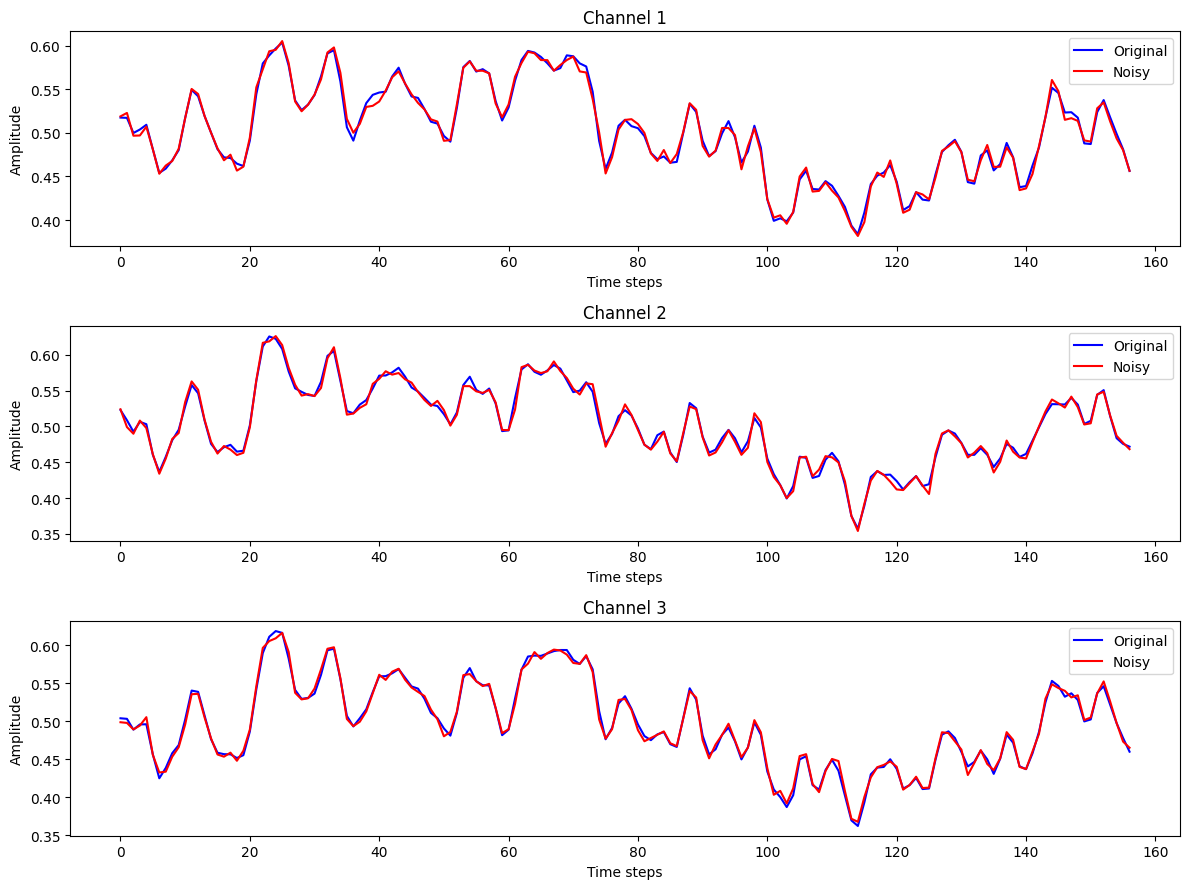

In [31]:
# Example usage:
# Assuming 'inputs', 'noisy_inputs', and 'denoised_outputs' are available
plot_eeg_time_series(inputs, noisy_inputs, denoised_data=None, channel_indices=[0, 1, 2], time_range=(100, 300))


In [14]:
# truths.shape

In [32]:
# Normalize data to range [0, 1] for consistency and to aid learning.
noisy_inputs = (noisy_inputs - np.min(noisy_inputs)) / (np.max(noisy_inputs) - np.min(noisy_inputs))
truths = (truths - np.min(truths)) / (np.max(truths) - np.min(truths))

In [33]:
# Split the data into training and testing sets to evaluate model performance.
x_train, x_test, y_train, y_test = train_test_split(noisy_inputs, truths, test_size=0.2, random_state=42)


In [34]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(4147, 22, 257)
(4147, 22, 257)
(1037, 22, 257)
(1037, 22, 257)


In [48]:
# Configure and compile the model
model = TransformerModel(time2vec_dim=1, num_heads=5, head_size=128, ff_dim=256, num_layers=2, dropout=0.1)
model.compile(optimizer='adam', loss='mean_squared_error')  # Use Adam optimizer and MSE loss function

In [49]:
# model.summary()

In [20]:
# Define a Learning Rate Scheduler to adjust the learning rate dynamically during training for better performance.
def lr_scheduler(epoch, lr):
    warmup_epochs = 15
    decay_epochs = 100
    initial_lr = 1e-6
    base_lr = 1e-3
    min_lr = 5e-5
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr
    if epoch > warmup_epochs and epoch < warmup_epochs + decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr
    return min_lr


In [50]:
callback_list = [LearningRateScheduler(lr_scheduler, verbose=1)]

# Train the model with the specified configurations.
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32) # callbacks=callback_list

Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - loss: 0.1358 - val_loss: 0.0024
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - loss: 0.0025 - val_loss: 0.0026


### Inference on test set

In [51]:
# Assuming 'model' is the trained Transformer model and 'x_test' is the test dataset

# Predict the outputs for the test set
predicted_outputs = model.predict(x_test)

# You can now use 'predicted_outputs' for further analysis, visualization, or post-processing
# For example, printing the shape of the outputs and some sample data
print("Shape of the predicted outputs:", predicted_outputs.shape)
# print("Sample predictions:", predicted_outputs[:5])

# If you need to compare these predictions with the actual labels
# Assuming 'y_test' contains the true values for the test set
# print("Actual true outputs:", y_train[:5])

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Shape of the predicted outputs: (1037, 22, 257)


In [52]:


# # calculate the performance metrics, 'Mean Squared Error'
from sklearn.metrics import mean_squared_error

# mse = mean_squared_error(y_train, predicted_outputs)
# print("Mean Squared Error on Test Set:", mse)


In [53]:
# Calculate MSE for each feature and average over all time steps
mse_per_feature = np.mean([mean_squared_error(y_test[:, i, :], predicted_outputs[:, i, :]) for i in range(y_test.shape[1])])
print("Mean Squared Error per feature, averaged over time steps:", mse_per_feature)

Mean Squared Error per feature, averaged over time steps: 0.0026396675050067084


In [45]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize a list or numpy array to store the MSE values for each channel
mse_per_channel = np.zeros((y_test.shape[1],))  # y_train.shape[1] should be 22 if there are 22 channels

# Loop through each channel and calculate MSE
for channel_index in range(y_test.shape[1]):
    # Extract the channel data for both true and predicted values
    true_channel_data = y_test[:, channel_index, :]
    predicted_channel_data = predicted_outputs[:, channel_index, :]

    # Compute the MSE for this channel
    mse_per_channel[channel_index] = mean_squared_error(true_channel_data, predicted_channel_data)

    # Optionally, print the MSE for each channel
    print(f"MSE for Channel {channel_index + 1}: {mse_per_channel[channel_index]}")


MSE for Channel 1: 0.002972928503347767
MSE for Channel 2: 0.0024629091292698285
MSE for Channel 3: 0.00276646752712943
MSE for Channel 4: 0.003054002334402725
MSE for Channel 5: 0.002860533942035442
MSE for Channel 6: 0.002704329651914335
MSE for Channel 7: 0.0017347323107162068
MSE for Channel 8: 0.002265104103764332
MSE for Channel 9: 0.002524735349487292
MSE for Channel 10: 0.0029096879237613107
MSE for Channel 11: 0.0027121437452935653
MSE for Channel 12: 0.0026937017349532334
MSE for Channel 13: 0.002263033058365439
MSE for Channel 14: 0.00237695476279208
MSE for Channel 15: 0.0024789688626387796
MSE for Channel 16: 0.0027029311309705517
MSE for Channel 17: 0.002689838349948741
MSE for Channel 18: 0.0028379722328487783
MSE for Channel 19: 0.0025295322376105104
MSE for Channel 20: 0.002779079981532564
MSE for Channel 21: 0.0027283391975382047
MSE for Channel 22: 0.0027965330171588055


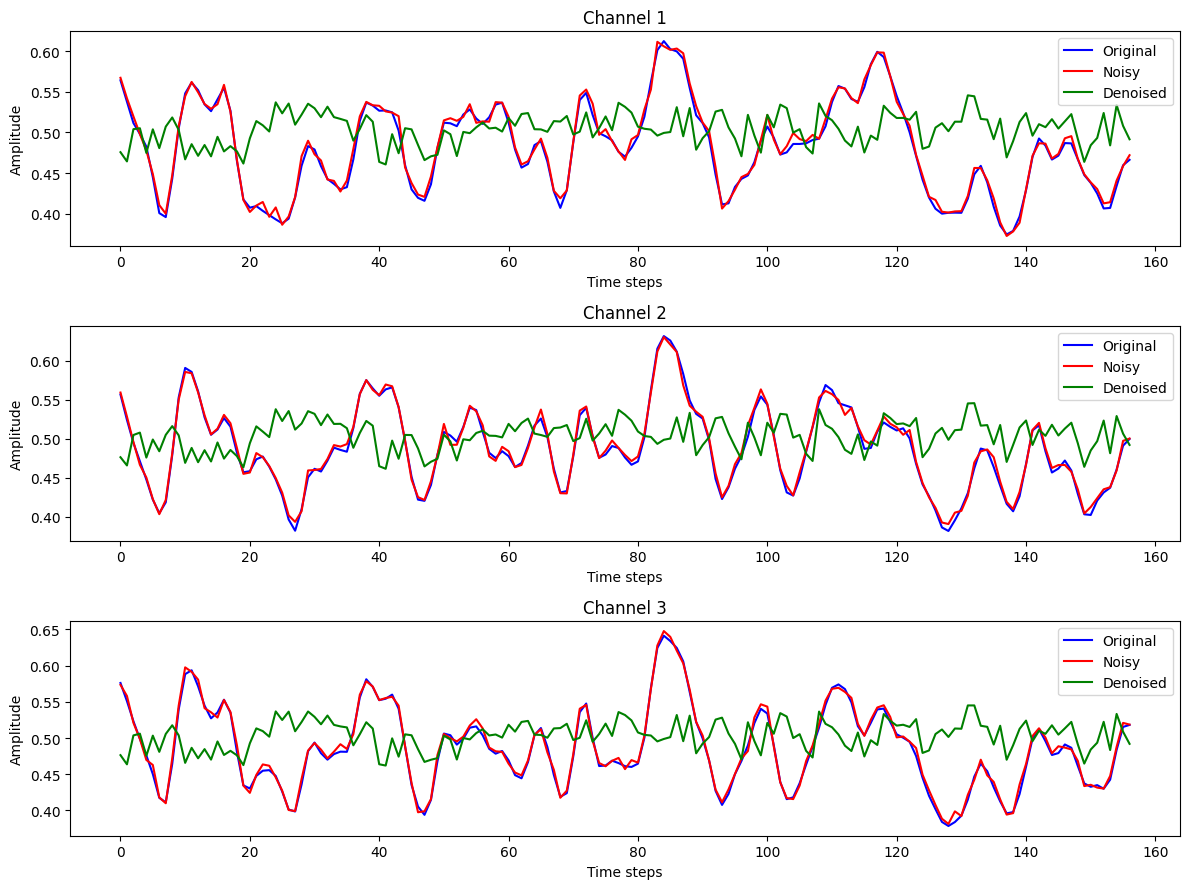

In [54]:
# Example usage:
# Assuming 'inputs', 'noisy_inputs', and 'denoised_outputs' are available
plot_eeg_time_series(y_test, x_test, denoised_data=predicted_outputs, channel_indices=[0, 1, 2], time_range=(100, 300))


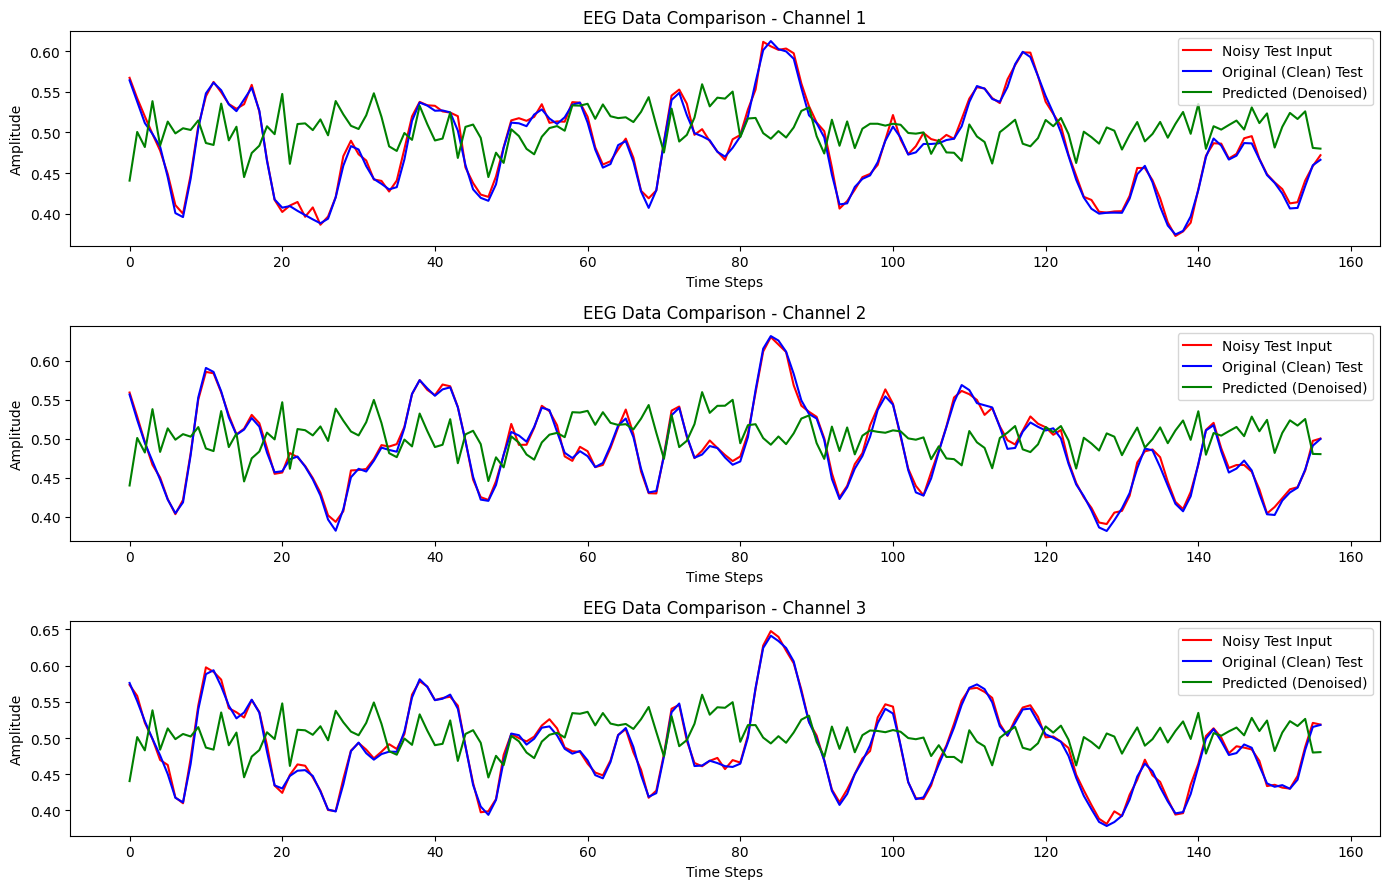

In [47]:
import matplotlib.pyplot as plt

def plot_comparison_eeg(x_test, y_test, predicted_outputs, channel_indices=[0], time_range=None, sample_index=0):
    """
    Plots comparison of EEG data for test input, test ground truth, and predicted outputs.

    Parameters:
    - x_test: numpy array of shape (samples, channels, time_steps), noisy EEG data used for testing.
    - y_test: numpy array of shape (samples, channels, time_steps), original EEG data (ground truth for testing).
    - predicted_outputs: numpy array of shape (samples, channels, time_steps), model's prediction on x_test.
    - channel_indices: list of integers, indices of the channels to plot.
    - time_range: tuple of (start, end), range of time steps to plot. Defaults to the full range.
    - sample_index: integer, index of the sample from the test set to plot.
    """
    # Define the time range to plot if not specified
    if time_range is None:
        time_range = (0, x_test.shape[2])  # Use the full range of time steps
    
    num_plots = len(channel_indices)
    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 3 * num_plots), squeeze=False)
    
    # Iterate over each specified channel index
    for i, channel_idx in enumerate(channel_indices):
        ax = axes[i][0]
        # Plot each dataset
        ax.plot(x_test[sample_index, channel_idx, time_range[0]:time_range[1]], label='Noisy Test Input', color='red')
        ax.plot(y_test[sample_index, channel_idx, time_range[0]:time_range[1]], label='Original (Clean) Test', color='blue')
        ax.plot(predicted_outputs[sample_index, channel_idx, time_range[0]:time_range[1]], label='Predicted (Denoised)', color='green')
        
        ax.set_title(f'EEG Data Comparison - Channel {channel_idx + 1}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Amplitude')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage of the function
# Assume x_test, y_test, and predicted_outputs are loaded with the correct shapes
plot_comparison_eeg(x_test, y_test, predicted_outputs, channel_indices=[0, 1, 2], time_range=(100, 300), sample_index=0)
